
# <center>Python for data analysis</center>
## <center>Final project | SkillCraft</center>  

------

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA as pca_skl
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import shap

%matplotlib inline

## Description of the dataset  

### Brief presentation

SkillCraft is a dataset composed of a lot of features of over three thousand players playing at StarCraft 2 from bronze to professionnal gamers. In ower study we will try to predict the league index of a player concidering all his others features. Thus, it is a classification problem.


### Origin of the dataset

   - Creators: Mark Blair, Joe Thompson, Andrew Henrey, Bill Chen 
   - Mark Blair: Department of Psychology; Simon Fraser University; Burnaby; 8888 University Drive; mblair '@' sfu.ca) 
   - Date: September, 20, 2013

### Information given by the creators :

   - We aggregated screen movements into screen-fixations using a Salvucci & Goldberg(2000) dispersion-threshold algorithm, 
      and defined Perception Action Cycles (PACs) as fixations with at least one action.

   - Time is recorded in terms of timestamps in the StarCraft 2 replay file. When the game is played on faster 1 real-time 
      second is equivalent to roughly 88.5 timestamps.

   - List of possible game actions is discussed in Thompson, Blair, Chen, & Henrey (2013)

### List of features :

- **GameID**: Unique ID number for each game (integer)
- **LeagueIndex**: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
- **Age**: Age of each player (integer)
-  **HoursPerWeek**: Reported hours spent playing per week (integer)
-  **TotalHours**: Reported total hours spent playing (integer)
-  **APM**: Action per minute (continuous)
-  **SelectByHotkeys**: Number of unit or building selections made using hotkeys per timestamp (continuous)
-  **AssignToHotkeys**: Number of units or buildings assigned to hotkeys per timestamp (continuous)
-  **UniqueHotkeys**: Number of unique hotkeys used per timestamp (continuous)
-  **MinimapAttacks**: Number of attack actions on minimap per timestamp (continuous)
-  **MinimapRightClicks**: number of right-clicks on minimap per timestamp (continuous)
-  **NumberOfPACs**: Number of PACs per timestamp (continuous)
-  **GapBetweenPACs**: Mean duration in milliseconds between PACs (continuous)
-  **ActionLatency**: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
-  **ActionsInPAC**: Mean number of actions within each PAC (continuous)
-  **TotalMapExplored**: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
-  **WorkersMade**: Number of SCVs, drones, and probes trained per timestamp (continuous)
-  **UniqueUnitsMade**: Unique unites made per timestamp (continuous)
-  **ComplexUnitsMade**: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
-  **ComplexAbilitiesUsed**: Abilities requiring specific targeting instructions used per timestamp (continuous)  

# Data Exploration

## First step

### Import data

In [5]:
dataset = pd.read_csv("SkillCraft1_Dataset.csv", index_col="GameID")
dataset.sort_index(inplace=True)
dataset.head()
print("Shape : ", dataset.shape)

Shape :  (3395, 19)


### Have a look on the types of the columns

In [6]:
dataset.dtypes

LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

<div class="alert alert-block alert-info">
    • We see here that some variables are continuous and others are discret. <b>Age</b>, <b>HoursPerWeek</b> and <b>TotalHours</b> are detected as Object but they are numeric values. Let's parse them to numeric.
</div>

In [7]:
#By using errors = 'coerce', we give the value NaN to the not numeric values instead of throwing an exception.
for col in ['Age', 'HoursPerWeek', 'TotalHours']:
    dataset[col] = pd.to_numeric(dataset[col], errors = 'coerce')

### Quality of values

<div class="alert alert-block alert-info">
    • Good, now all the columns are well defined, we now want to see <b>if there are missing datas</b> and see how we can deal with it (Delete the columns ? The observations ? Give a default value (mean of the column) ?)<br><br>
    So let's have a look on missed values (NaN/NA/0/...)
</div>

In [8]:
dataset.isnull().sum()

LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

<div class="alert alert-block alert-info">
    • We can see that <b>Age</b> contains 55 NaN values, <b>HoursPerWeek</b> contains 56 NaN values and <b>TotalHours</b> 57 NaN values.  
    Let's check this.
</div>

In [9]:
dataset[dataset['Age'].isnull()].head(3)
dataset[dataset['Age'].isnull()].tail(3)

,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
GameID,,,,,,,,,,,,,,,,,,,
10092,8,NaN,NaN,NaN,299.4282,0.028341,0.000860,7,0.000338,0.000169,0.004439,12.4028,39.5156,6.3979,19,0.001260,4,0.000000,0.000000
10094,8,NaN,NaN,NaN,375.8664,0.036436,0.000594,5,0.000204,0.000780,0.004346,11.6910,34.8547,7.9615,15,0.000613,6,0.000000,0.000631
10095,8,NaN,NaN,NaN,348.3576,0.029855,0.000811,4,0.000224,0.001315,0.005566,20.0537,33.5142,6.3719,27,0.001566,7,0.000457,0.000895


<div class="alert alert-block alert-info">    
   • We can see that all the Professional leagues players (8) misses their age, their total hours and their HoursPerWeek. Maybe we shouldn't delete those observations, because knowing about professional players can be really helpfull. We might just want to <b>change those value to their respective mean value</b>.
</div>

In [10]:
dataset.fillna(dataset.mean(), inplace=True)

### Check if all is good

In [11]:
dataset.isnull().sum()

LeagueIndex             0
Age                     0
HoursPerWeek            0
TotalHours              0
APM                     0
SelectByHotkeys         0
AssignToHotkeys         0
UniqueHotkeys           0
MinimapAttacks          0
MinimapRightClicks      0
NumberOfPACs            0
GapBetweenPACs          0
ActionLatency           0
ActionsInPAC            0
TotalMapExplored        0
WorkersMade             0
UniqueUnitsMade         0
ComplexUnitsMade        0
ComplexAbilitiesUsed    0
dtype: int64

In [12]:
dataset.dtypes

LeagueIndex               int64
Age                     float64
HoursPerWeek            float64
TotalHours              float64
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

<div class="alert alert-block alert-info"> 
• Alright ! We are ready to start !
</div>

### Check the range / mean / std... of each features

In [13]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
LeagueIndex,3395.0,4.184094,1.517327,1.000000,3.000000,4.000000,5.000000,8.000000
Age,3395.0,21.647904,4.172119,16.000000,19.000000,21.000000,24.000000,44.000000
HoursPerWeek,3395.0,15.910752,11.863809,0.000000,8.000000,12.000000,20.000000,168.000000
TotalHours,3395.0,960.421809,17172.094828,3.000000,300.000000,500.000000,800.000000,1000000.000000
APM,3395.0,117.046947,51.945291,22.059600,79.900200,108.010200,142.790400,389.831400
SelectByHotkeys,3395.0,0.004299,0.005284,0.000000,0.001258,0.002500,0.005133,0.043088
AssignToHotkeys,3395.0,0.000374,0.000225,0.000000,0.000204,0.000353,0.000499,0.001752
UniqueHotkeys,3395.0,4.364654,2.360333,0.000000,3.000000,4.000000,6.000000,10.000000
MinimapAttacks,3395.0,0.000098,0.000166,0.000000,0.000000,0.000040,0.000119,0.003019
MinimapRightClicks,3395.0,0.000387,0.000377,0.000000,0.000140,0.000281,0.000514,0.004041


<div class="alert alert-block alert-info">
<b>Analyse:</b> <ul>
    <li>We can see that someone has been playing 168 hours/week which means he/she plays 24h/24 this seems unrealistic.</li>
     <li>We can see that someone has been playing 1 000 000 hours which means he/she played more than 100 years this is unrealistic.</li>
    <li>The rest seems pretty coherent but let's check this more in detail. </li>
</ul>
</div>

<div class="alert alert-block alert-info">
    First, let's <b>delete people playing more than 150 hours a week</b> which is the limit acceptable (2 hours of sleep).
</div>

In [14]:
dataset.drop(dataset[dataset['HoursPerWeek']>150].index, inplace = True) 

<div class="alert alert-block alert-info">
    And now, <b>delete people playing more than 123 000 hours</b> which is the limit acceptable (14 years - since the game appeared in 1999).
</div>

In [15]:
dataset.drop(dataset[dataset['TotalHours']>123000].index, inplace = True) 

## Overview plots

### Histogramm

<div class="alert alert-block alert-info">
• Let's have a look on the distribution of each features
</div>

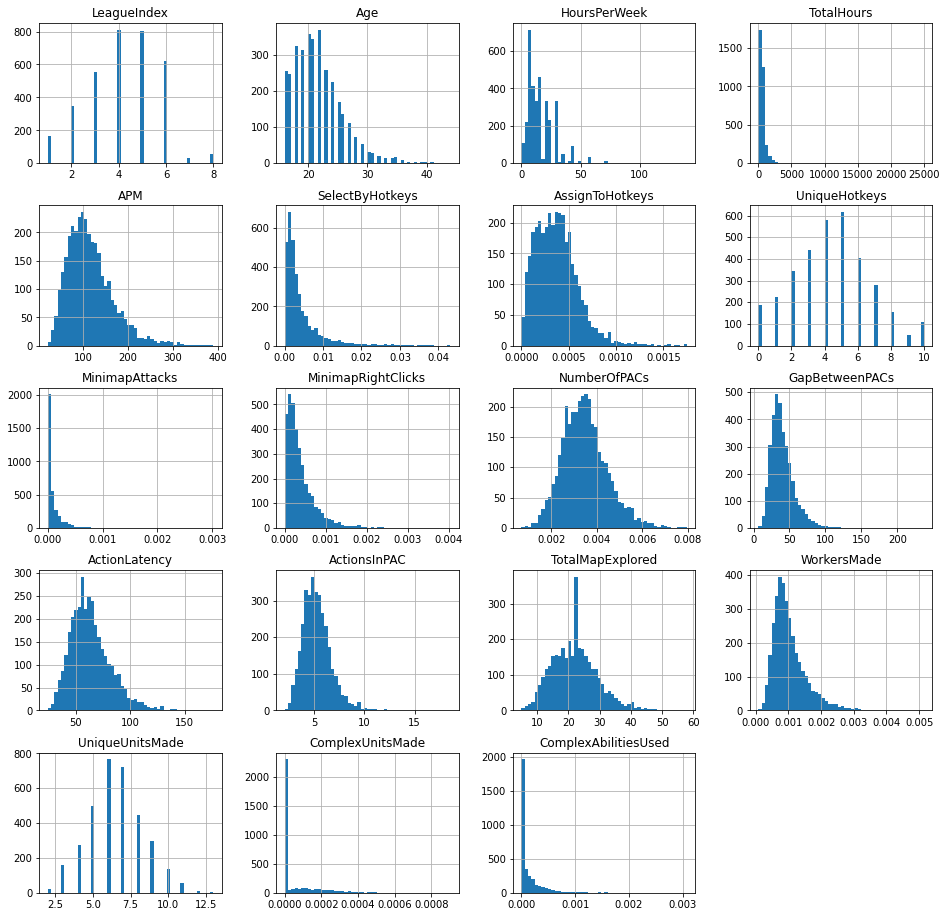

In [16]:
dataset.hist(bins=50, figsize=(16, 16));

<div class="alert alert-block alert-info">
<b>Analyse:</b> <ul>
    <li>It seems to have a lot of player having a level between 1 and 6, then the number drops sharply, it might be a <b>problem to predict well 7 and 8 level players</b>.</li>
     <li>The major part of the features have a normal or poisson distribution. It can be a good idea to proceed to a <b>log transformation</b> for the features stocked on the left side.</li>
    <li>It seems important to <b>normalize and centralize</b> the data inorder to be able to compare them. </li>
</ul>
</div>

### Correlation matrix

<div class="alert alert-block alert-info">
    • A good idea now would be to check the <b>correlation between each features</b>.
</div>

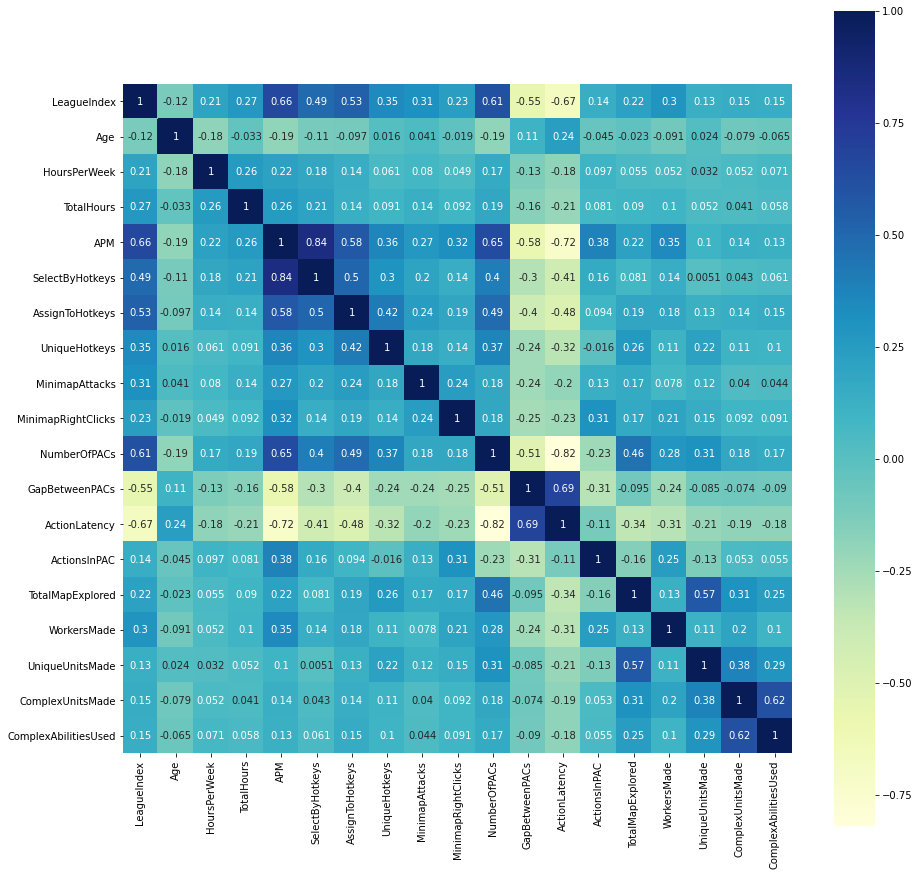

In [17]:
plt.figure(figsize=(15, 15))
sns.heatmap(dataset.corr(),
            cmap='YlGnBu',
            annot=True, 
            square=True);

<div class="alert alert-block alert-info">
<b>Analyse:</b> <ul>
    <li>Here we could expect that <b>Age</b> and the <b>League index</b> are correlated but, it is not the case and it seems to have good player among the young and old !</li>
     <li>We see that it is the more technical features which are the most predictive of player's level, like <b>ActionLatency</b> (- 0.67), <b>APM</b> (0,66), <b>NumberOfPACs</b> (0.61), <b>GapBetweenPACs</b> (-0.55) or <b>AssignToHotKeys</b> (0.53).</li>
    <li>So, we progressively dress the typical profil of a good player : low latency, quick reaction, use the hotkeys to select their units (which is also correlated to the reaction) etc... </li>
</ul>
</div>

### KDE of interesting features

<div class="alert alert-block alert-info">
    • So, let's have a look on the <b>KDE</b> of some of the features we have seen before
</div>

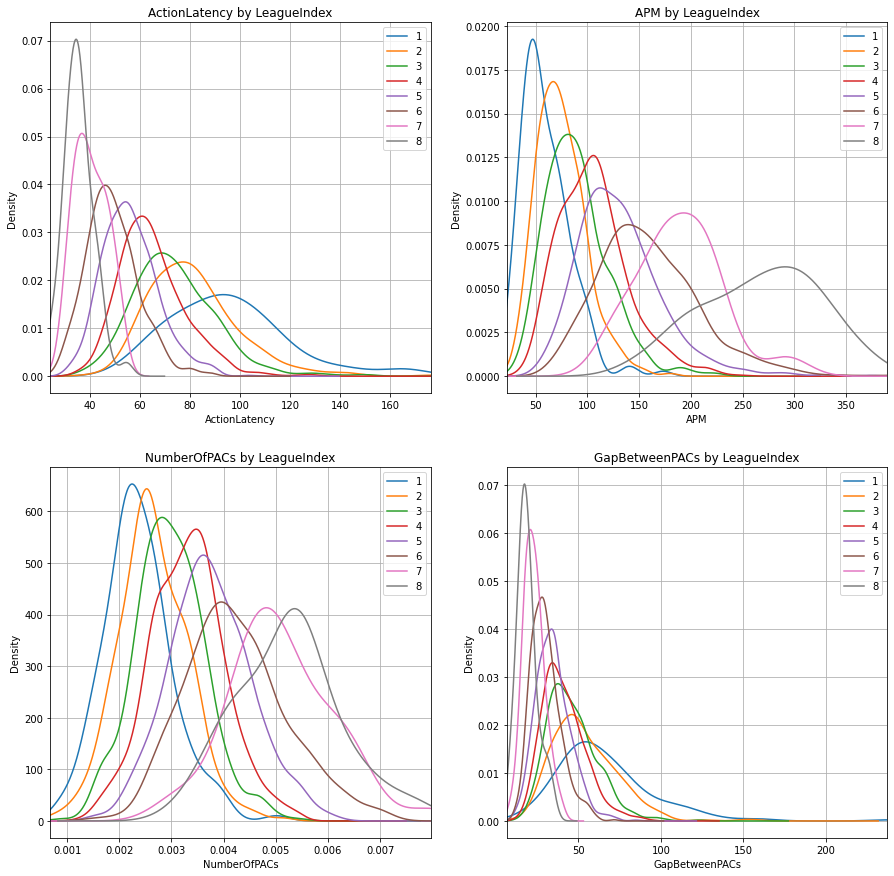

In [18]:
for k, feature in enumerate(['ActionLatency', 'APM', 'NumberOfPACs', 'GapBetweenPACs']):
    plt.subplot(2, 2, k+1);
    dataset.groupby('LeagueIndex')[feature].plot.kde(legend=True, 
                                                     figsize=(15, 15),
                                                    xlim=(min(dataset[feature]), 
                                                          max(dataset[feature])),
                                                    ylabel="Density",
                                                    grid=True,
                                                    title=f"{feature} by LeagueIndex");
    plt.xlabel(feature);
plt.show();

- For the two first plots (APM and League Index) the means for each league index are well separate and comfort the idea that it is good features to predict the player's level. However SelectByHotkeys seems to be a good predictor only for the best player. It means that the player having a score between 0 and 6 don't use hot key but when we have a level at 7 or 8 we must improve all our techniques and use hot keys can be an axe of improvment.

<div class="alert alert-block alert-info">
<b>Observations : </b> 
    <ul>
        <li>The different <b>gaussian seems to have really separated mean</b> which is good to predict the player's level.</li>
        <li>Level <b>7 and 8 seems to be very special</b> because they have mean really hight compare to the other. We could check this on boxplot...</li>
    </ul>
</div>

### Boxplot

<div class="alert alert-block alert-info">
    • Let's have a look on the <b>boxplot</b> of some of our previous features.
</div>

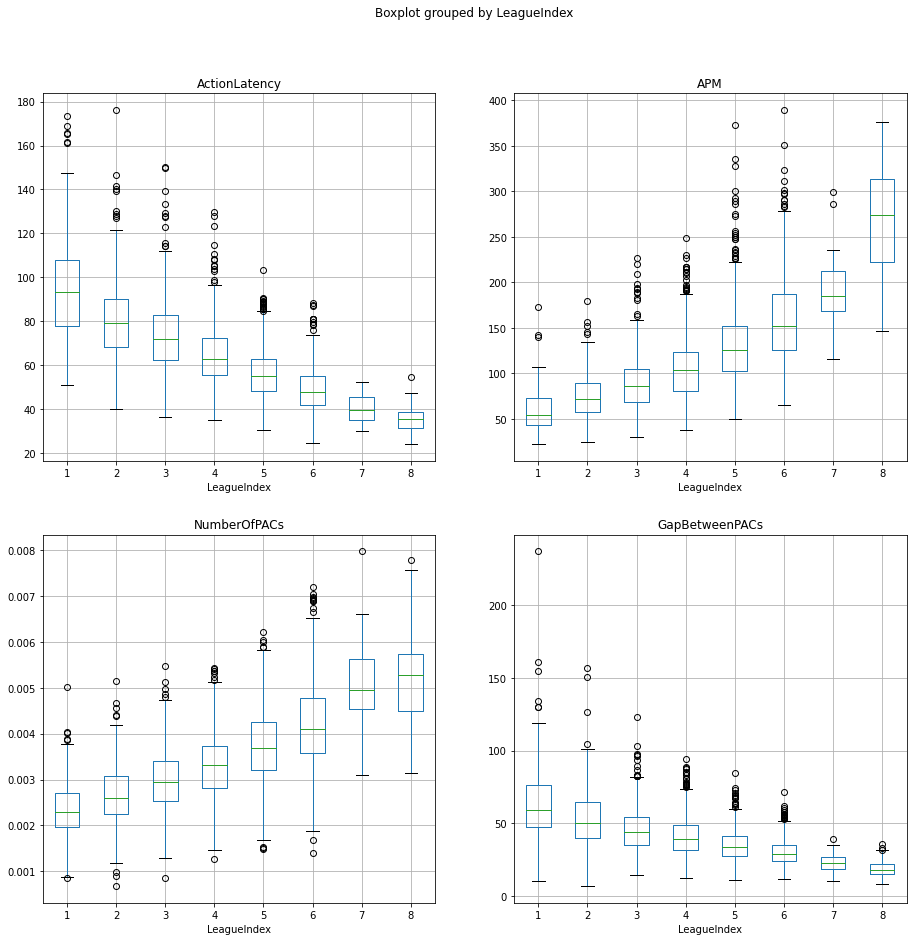

In [19]:
fig = plt.figure(figsize=(15, 15));
for k, col in enumerate(['ActionLatency', 'APM', 'NumberOfPACs', 'GapBetweenPACs']):
    ax = fig.add_subplot(2, 2, k+1);
    dataset.boxplot(column=[col], by="LeagueIndex", ax=ax);

<div class="alert alert-block alert-info">
<b>Observations : </b> 
    <ul>
        <li><b>We comfirm here what we said earlier</b>: these four features have really separated mean and level 7 and 8 are really similar but different from the others levels.<li>According to the corrplot we also find that <b>ActionLatency is the best indicator</b>, but it is not perfect as the range of values are quite large.</li></ul>
</div>

### Scatter matrix

<div class="alert alert-block alert-info">
• Finally, let's select our previous best feautres, plot them, and color the observation with the league index.
</div>

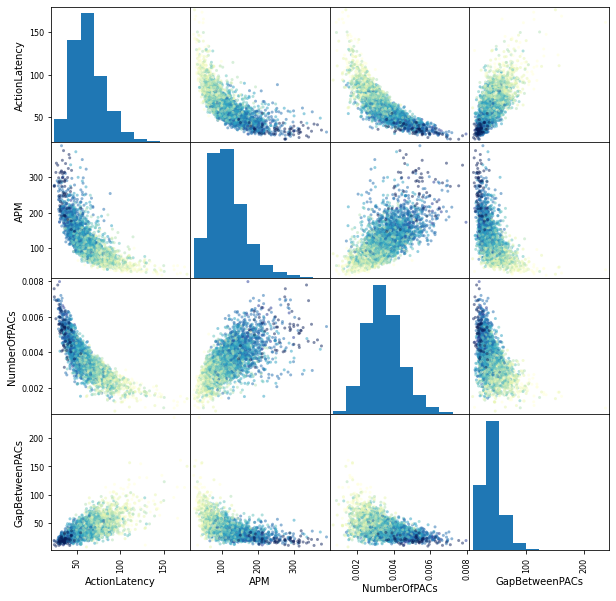

In [20]:
interesting_features = ['ActionLatency', 'APM', 'NumberOfPACs', 'GapBetweenPACs']

pd.plotting.scatter_matrix(dataset[interesting_features], 
                           c=dataset['LeagueIndex'],
                           cmap='YlGnBu',
                           figsize=(10, 10),
                           label=dataset['LeagueIndex']);

<div class="alert alert-block alert-info">
<b>Observations : </b> 
    <ul>
        <li>Great! We can see with these plots that <b>Action Latency seems to be a good classifier </b> with the 3 others features that are also well correlated with League Index. Indeed, bigger is the Action latency bigger is the league index</li>
        <li><b>GapBetweenPACs</b> seem to be less interesting, maybe a log transformation would be a good idea ?</li>
        <li>But as we can see, there aren't clear clusters that would allow us to create a great model with those features. We can already say that <b>we surely should ask for more informations about the players</b> (life habits ? Player's Jobs? Players Salary? ... ).</li>
    </ul>
</div>

## Data Prepocessing

### Data engineering

<div class="alert alert-block alert-info">
    • The idea here is <b>can we create new columns that would be more relevent to the league index</b> ? We saw that log transformation could be a good idea for the features who are right-skewed (see the histogram plot of the different features) 
    So let's see if some features are at least as relevent when passed under a logarithmic function.
</div>

In [21]:
col_to_log = []
for col in dataset.drop(['LeagueIndex'], axis=1).columns:
    if 0 not in dataset[col]:
        normal = dataset['LeagueIndex'].corr(dataset[col])
        logged = dataset['LeagueIndex'].corr(np.log(dataset[col]))

        if(abs(logged)>abs(normal)):
            col_to_log.append(col)
        print(col, ":\n normal correlation = ", normal,
              "\n log correlation = ",logged,"\n")

col_to_log 

Age :
 normal correlation =  -0.12044380658772785 
 log correlation =  -0.09869300586819178 

HoursPerWeek :
 normal correlation =  0.20680399794210375 
 log correlation =  nan 

TotalHours :
 normal correlation =  0.27024402724647306 
 log correlation =  0.5041492509772076 

APM :
 normal correlation =  0.6626543103333653 
 log correlation =  0.6916251765475502 

SelectByHotkeys :
 normal correlation =  0.4906687271572481 
 log correlation =  nan 

AssignToHotkeys :
 normal correlation =  0.5308713957981165 
 log correlation =  nan 

UniqueHotkeys :
 normal correlation =  0.35071596310161585 
 log correlation =  nan 

MinimapAttacks :
 normal correlation =  0.31252552388558974 
 log correlation =  nan 

MinimapRightClicks :
 normal correlation =  0.2334150268292373 
 log correlation =  nan 

NumberOfPACs :
 normal correlation =  0.6119985119166921 
 log correlation =  0.6084750962691974 

GapBetweenPACs :
 normal correlation =  -0.5530710148109355 
 log correlation =  -0.5708597541626

divide by zero encountered in log


['TotalHours',
 'APM',
 'GapBetweenPACs',
 'ActionLatency',
 'ActionsInPAC',
 'TotalMapExplored',
 'WorkersMade']

<div class="alert alert-block alert-info">
• Great! We have a list of features were a log transformation could be a good idea.
• Let's do it !
</div>

In [22]:
for col in col_to_log:
    dataset[f"log({col})"] = np.log(dataset[col])

In [23]:
abs(dataset.corr()['LeagueIndex']).sort_values(ascending=False)

LeagueIndex              1.000000
log(ActionLatency)       0.694786
log(APM)                 0.691625
ActionLatency            0.673797
APM                      0.662654
NumberOfPACs             0.611999
log(GapBetweenPACs)      0.570860
GapBetweenPACs           0.553071
AssignToHotkeys          0.530871
log(TotalHours)          0.504149
SelectByHotkeys          0.490669
log(WorkersMade)         0.352109
UniqueHotkeys            0.350716
MinimapAttacks           0.312526
WorkersMade              0.295644
TotalHours               0.270244
MinimapRightClicks       0.233415
log(TotalMapExplored)    0.222045
TotalMapExplored         0.219878
HoursPerWeek             0.206804
log(ActionsInPAC)        0.186924
ComplexUnitsMade         0.148266
ComplexAbilitiesUsed     0.145422
ActionsInPAC             0.143141
UniqueUnitsMade          0.132999
Age                      0.120444
Name: LeagueIndex, dtype: float64

<div class="alert alert-block alert-info">
    • <b>log(ActionLatency) and log(APM) are really correlated with LeagueIndex</b>. Hope it will help the model in the prediction !
</div>


### Split in train and test set

<div class="alert alert-block alert-info">
    • First, let's <b>split the dataset and shuffle it</b>.
</div>

In [24]:
X = dataset.drop(['LeagueIndex'], axis=1).to_numpy()
Y = dataset['LeagueIndex'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.3)

print('X:', X_train.shape, X_test.shape)
print('Y:', y_train.shape, y_test.shape)

X: (2375, 25) (1018, 25)
Y: (2375,) (1018,)


### Normalize data

In [25]:
scl = sk.preprocessing.StandardScaler()

X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)

### Visualization of the p-values to continue preprocessing 

In [68]:
from sklearn.feature_selection import f_classif

F, pvalues = f_classif(X, Y)

com_dic = {'X':dataset.drop(['LeagueIndex'], axis=1).columns,'p-values':pvalues}
result = pd.DataFrame(com_dic).sort_values(by="p-values")
print(result)

                        X       p-values
21     log(ActionLatency)   0.000000e+00
19               log(APM)   0.000000e+00
11          ActionLatency   0.000000e+00
3                     APM   0.000000e+00
9            NumberOfPACs   0.000000e+00
20    log(GapBetweenPACs)  2.065150e-289
4         SelectByHotkeys  3.936017e-282
5         AssignToHotkeys  3.438514e-274
10         GapBetweenPACs  2.657307e-271
18        log(TotalHours)  1.371356e-216
24       log(WorkersMade)  3.732266e-108
6           UniqueHotkeys  2.450110e-102
7          MinimapAttacks   6.555523e-95
14            WorkersMade   6.654272e-72
2              TotalHours   2.784831e-57
1            HoursPerWeek   9.344632e-51
8      MinimapRightClicks   1.227090e-42
13       TotalMapExplored   5.606607e-37
23  log(TotalMapExplored)   5.974761e-37
22      log(ActionsInPAC)   1.112156e-27
16       ComplexUnitsMade   1.324249e-21
17   ComplexAbilitiesUsed   5.733238e-16
12           ActionsInPAC   2.322956e-15
15        Unique

<div class="alert alert-block alert-info">
    • <b>We can see that all the p-values are superior to alpha = 0.05, so they seem to be all significatif to the League Index</b>. In a result, we can't decide to drop columns right now. 
</div>

In [97]:
#Try Naive Bayes
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
gnb.score(X_test_scaled, y_test)

0.3418467583497053

## Modeling

<div class="alert alert-block alert-info">
    • It's time now to create some models !
</div>

### Linear Discriminant Analysis (LDA)

<div class="alert alert-block alert-info">
    • Let's start with a basic <b>LDA</b>
</div>

In [101]:
lda_clf = LinearDiscriminantAnalysis()
lda_clf.fit(X_train_scaled, y_train)
lda_clf.score(X_test_scaled, y_test)

0.4302554027504912

In [102]:
lda_clf.get_params() #VICTOR J4AI TROUV2 QUE CA COMME "SUMMARY" MAIS JE NE VOIS PAS TROP L'INTEREt

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

<div class="alert alert-block alert-info">
    <ul>
    <li>Okay, we have our starter point: <b>0.43</b>. LDA is a basic model, hope we will have better !</li>
    <li>Let's have a look on the confusion matrix :</li>
    </ul>
</div>

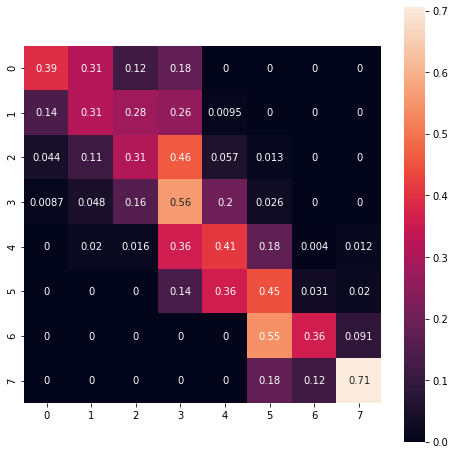

In [27]:
conf_matrix = confusion_matrix(y_test, lda_clf.predict(X_test_scaled),
                                normalize='true')
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix,
            annot=True, 
            square=True);

<div class="alert alert-block alert-info">
    <ul>
        <li>We can see that it has mainly a big difficulty predicting leagues <b>Index 7, 2, 1 and 3</b>...</li>
    <li>We also note that when the classifier make a mistake he mainly choose the next or previous level (5 instead of 6 / 3 instead of 2 ...)</li>
        <li>Maybe we can do better ? </li>
    </ul>
</div>

### Logistic Regression

<div class="alert alert-block alert-info">
    • Now we can try a <b>logistic regression</b>. We make 10000 epochs.
</div>

In [28]:
lgr_clf = LogisticRegression(max_iter=10000)
lgr_clf.fit(X_train_scaled, y_train)
lgr_clf.score(X_test_scaled, y_test)

0.4449901768172888

<div class="alert alert-block alert-info">
   <ul>
    <li>Here we get an accuracy of <b>0.445</b> it is better but not incredible. However, concidering the lack of data it is not surprising.</li>
    <li>Let's have a look on the confusion matrix :</li>
    </ul>
</div>

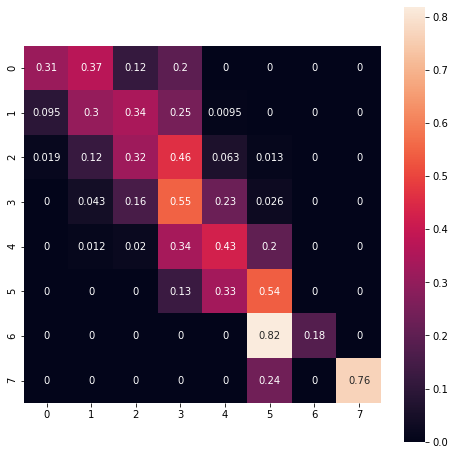

In [29]:
conf_matrix = confusion_matrix(y_test, lgr_clf.predict(X_test_scaled),
                               normalize='true')
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix,
            annot=True, 
            square=True);

<div class="alert alert-block alert-info">
    • Same observations as with LDA. With <b>big improvement for level 7</b> but less good predictions for others classes.. Let's see the importance of the different features for this linear regression.
</div>

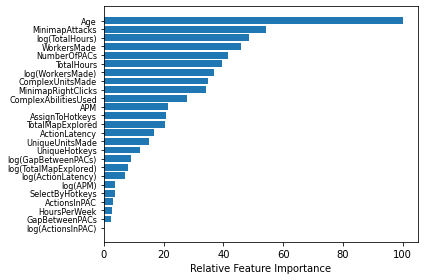

In [113]:
feature_importance = abs(lgr_clf.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(dataset.drop(columns=['LeagueIndex']).columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

<div class="alert alert-block alert-info">
    We can see that the lr model is mainly leaning on the Age feature while Age was the least relevent to the League Index when we saw the covariance matrix. Let's try dropping this feature.
</div>

In [150]:
#VICTOR : Si tu veux pas le mettre c'est comme tu veux, j'explique c que j'ai fait ici et tu le met ou pas comme tu veux
#J'ai garder que le log qui faisais un plus grands changement dans la correlation avec League index soit 
# log(TotalHours) (+0,23) et j'ai drop tous les autres log et les features qui ont une faible correlation avec League
#Index (<0,25) et qui ne sont pas amélioré par le log ou que le log retourne Nan SAUF UniqueAbilitiesUsed (et je sais pas
#pourquoi mais il ne faut pas le drop celui la ! )...  Soit : j'ai drop Age,HPW,MinimapRightClic, UniqueUnitsMade,
#ComplexUnitsMade. A toi de voir --


test = dataset.drop(['Age','MinimapRightClicks','HoursPerWeek','UniqueUnitsMade','ComplexUnitsMade',
                                  'log(ActionsInPAC)','log(ActionLatency)','log(WorkersMade)','log(APM)',
                    'log(TotalMapExplored)','log(GapBetweenPACs)'],axis=1)

#'log(WorkersMade)',log(APM)','MinimapRightClicks''Age','HoursPerWeek'
X = test.drop(['LeagueIndex'], axis=1).to_numpy()
Y = test['LeagueIndex'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, Y, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    test_size=0.3)

scl = sk.preprocessing.StandardScaler()

X_train_scaled = scl.fit_transform(X_train)
X_test_scaled = scl.transform(X_test)

lgr_clf = LogisticRegression(max_iter=10000)
lgr_clf.fit(X_train_scaled, y_train)
lgr_clf.score(X_test_scaled, y_test)

0.45579567779960706

### RandomForest

<div class="alert alert-block alert-info">
    • Let's try a RandomForest classifier
</div>

In [30]:
rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(X_train, y_train)
rf_clf.score(X_test, y_test)

0.4292730844793713

<div class="alert alert-block alert-info">
    • It's pretty bad and a grid search would take a very long time on it...
</div>

### KNeighbors Classifier

<div class="alert alert-block alert-info">
    • Finaly, let's try a KNN
</div>

In [31]:
knn_clf = KNeighborsClassifier(n_neighbors=k)
knn_clf.fit(X_train_scaled, y_train)
knn_clf.score(X_test_scaled, y_test)

0.32612966601178783

<div class="alert alert-block alert-info">
    • It's not good, but let's make a grid search !
</div>

In [32]:
grid  = {
    'n_neighbors':range(1, 30),
    'weights':['uniform', 'distance'],
    'metric':['euclidean', 'manhattan']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid,
    verbose = 1,
    cv = 5,
    n_jobs = -1)


In [33]:
res = gs.fit(X_train_scaled, y_train)
res.best_estimator_
res.score(X_test_scaled, y_test)

Fitting 5 folds for each of 116 candidates, totalling 580 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 554 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 565 out of 580 | elapsed:    6.2s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 580 out of 580 | elapsed:    6.3s finished


0.4076620825147348

<div class="alert alert-block alert-info">
    • It's better but definitively not the model to choose..
</div>

## Optimisation attempts

<div class="alert alert-block alert-info">
    <ul>
    <li>We have tested a lot of models, great! Now it's time to choose one. According to the previosu results we choose the <b>logistic regression model</b>.</li>
        <li>Now we can try to improve our models with differennts technics and tricks</li>
    </ul>
</div>

### Polynomial features

<div class="alert alert-block alert-info">
    • First, we can check if polynomials features would increase the model accuracy
</div>

In [34]:
pipeline = Pipeline([
                    ('scaler', sk.preprocessing.StandardScaler()),
                    ('poly', sk.preprocessing.PolynomialFeatures()),
                    ('lgr', LogisticRegression(max_iter=10000))])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('poly', PolynomialFeatures()),
                ('lgr', LogisticRegression(max_iter=10000))])

In [35]:
pipeline.score(X_test, y_test)

0.38605108055009824

<div class="alert alert-block alert-info">
    • We loose in accuracy. <b>Polynomial features are not a good idea</b>. move on !
</div>

### Power transform

<div class="alert alert-block alert-info">
    • We can also try to check if a normal distribution have an impact on our model
</div>

In [36]:
pipeline = Pipeline([
                    ('scaler', sk.preprocessing.StandardScaler()),
                    ('lgr', LogisticRegression(max_iter=10000))])

X_transform = sk.preprocessing.power_transform(X_train)
pipeline.fit(X_transform, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lgr', LogisticRegression(max_iter=10000))])

In [37]:
pipeline.score(X_test, y_test)

0.04027504911591356

<div class="alert alert-block alert-info">
    • We have here loose all our information ! 
</div>

### Grid search CV

<div class="alert alert-block alert-info">
    • Search the best estimator for our model
</div>

In [ ]:
grid  = {
    "C": np.logspace(-4, 4, 20),
    "penalty": ["l1", "l2", "elasticnet"],
    'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
    }

gs = GridSearchCV(
    LogisticRegression(max_iter=10000),
    grid,
    verbose = 1,
    cv = 5,
    n_jobs = -1)

res = gs.fit(X_train_scaled, y_train)
res.best_params_
res.score(X_test_scaled, y_test)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 1330 tasks      | elapsed:  6.7min


<div class="alert alert-block alert-info">
    • We have here a score ...
</div>

### Define our final model with pipeline

<div class="alert alert-block alert-info">
    • Let's define properly our final model
</div>

In [39]:
model = Pipeline([
                  ('scaler', sk.preprocessing.StandardScaler()),
                  ('lr', LogisticRegression(random_state=42, 
                                            max_iter=10000))])
model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000, random_state=42))])

## Validation

<div class="alert alert-block alert-info">
    • Okay great, we have our model. Now let's analyse more in details the results.
</div>

### PCA

<div class="alert alert-block alert-info">
    • We can proceed to a PCA inorder to have a more concrete observation of the classification.
</div>

In [40]:
def make_PCA(X_test, y_test, y_pred):

    colors = ['blue', 'green', 'red', 'orange', 'brown', 'purple', 'yellow', 'black']
    
    #Apply PCA
    projected_xi = (pca_skl(n_components=2)
                    .fit_transform(X_test))

    data = {'predict':{k+1: projected_xi[y_pred == k+1] for k in range(8)},
            'real':{k+1: projected_xi[y_test == k+1] for k in range(8)}}
    
    success = {True:projected_xi[y_pred == y_test], 
               False:projected_xi[y_pred != y_test]}
        
    #Plot on factorial plan
    plt.figure(figsize=(15, 20))
    plt.subplot(2, 1, 1)

    for k in range(len(data['real'])):
        x_predict = np.asarray(data['predict'][k+1])[:, 0]
        y_predict = np.asarray(data['predict'][k+1])[:, 1]
        
        x_real = np.asarray(data['real'][k+1])[:, 0]
        y_real = np.asarray(data['real'][k+1])[:, 1]

        plt.scatter(x_predict, y_predict,
                    alpha=0.6,
                    s=5,
                    color=colors[k],
                    label='predict'+str(list(data['predict'].keys())[k]))
        
        plt.scatter(x_real, y_real,
                    alpha=0.2,
                    s=5*8,
                    color=colors[k],
                    label='real'+str(list(data['real'].keys())[k]))
    plt.legend()
    plt.title("Compare real and predicted labels")
    
    plt.subplot(2, 1, 2)
    for state in (True, False):
        x = np.asarray(success[state])[:, 0]
        y = np.asarray(success[state])[:, 1]
        plt.scatter(x, y,
                    alpha=0.6,
                    s=20,
                    color='green' if state else 'red',
                    label='Correct' if state else 'Uncorrect')
    plt.legend()
    plt.title("Correctand uncorrect predicted labels")
    
    plt.show()

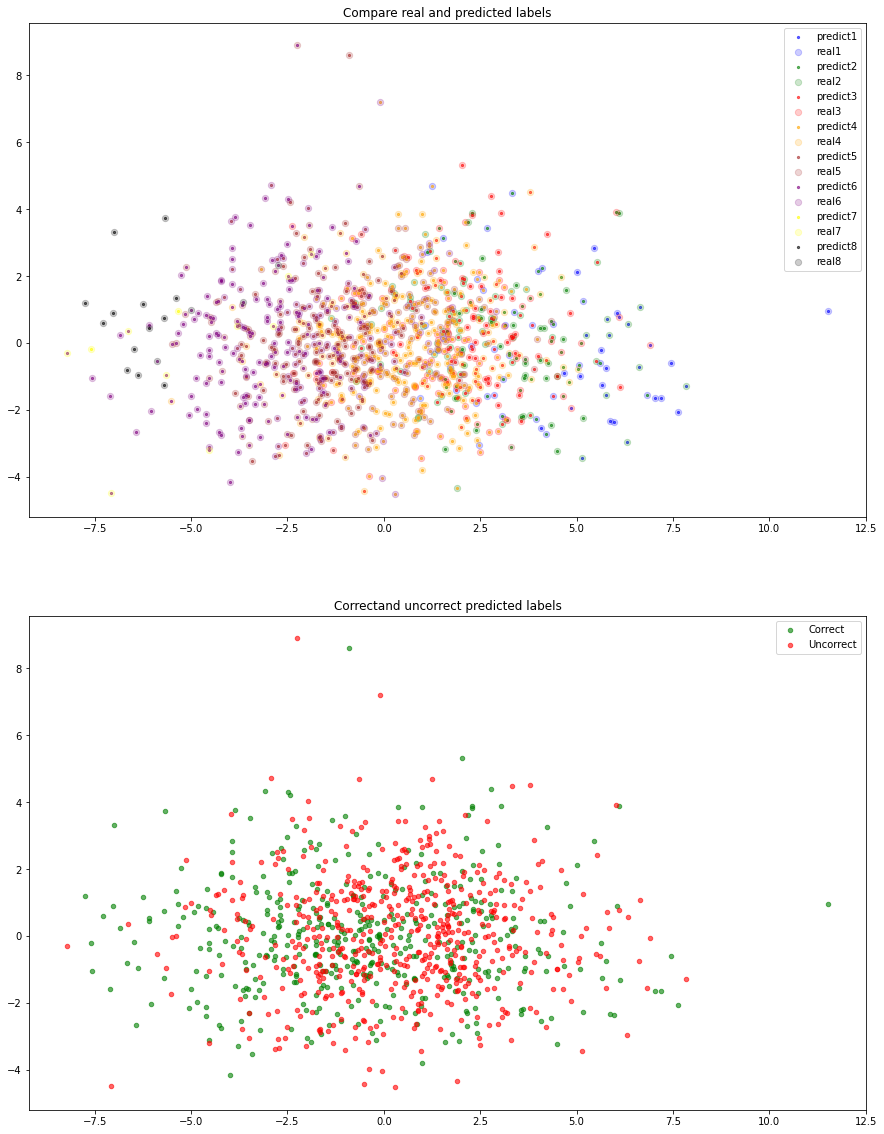

In [41]:
make_PCA(X_test_scaled, y_test, model.predict(X_test))

<div class="alert alert-block alert-info">
    <ul>
        <li>We can see the different distinct clusters on the first plot</li>
    <li>The results are mitigated. Indeed our model do not seems to be better in a specific class, it make mainly same mistake for all levels players.</li>
        </ul>
</div>

### Shap values

<div class="alert alert-block alert-info">
    • We can also have a look on the most predictive features for our model.
</div>

In [42]:
explainer = shap.LinearExplainer(lgr_clf, X_train)
shap_values = explainer.shap_values(X_test)

The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


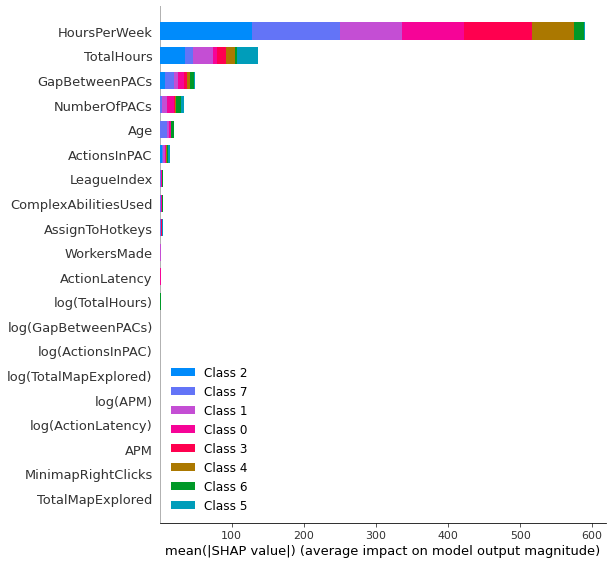

In [43]:
shap.summary_plot(shap_values, X_test, feature_names=dataset.columns)

<div class="alert alert-block alert-info">
    • We can see that this is not APM or ActionLatency which contribute the most to the creation of the model but HoursPerWeek which is the most significant here.
</div>

## Save model

<div class="alert alert-block alert-info">
    • Finally, let's save our model 
</div>

In [44]:
#save model
filename = "lda_model_LeagueIndex.pickle"
with open(filename, 'wb') as file:
    pickle.dump(lda_clf, file)

## Conclusion

...